

---


To run this demonstrator:

choose ***Run all*** from ***Runtime***

---



In [ ]:
import random as rnd
from scipy.stats import entropy
from math import e
import csv
import numpy as np
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import statistics
data = open("results.csv", "w")

global dnumber
global dsize
global dstr

In [ ]:
def landscape(roughness):
    """
    The landscape function creates a two dimensional fractal matrix of 1 and -1
    """
    levels = 7
    size = 2 ** (levels - 1)
    height  = np.zeros((size + 1, size + 1))

    for lev in range(levels):
        step = size // 2 ** lev
        for y in range(0, size + 1, step):
            jumpover = 1 - (y // step) % 2 if lev > 0 else 0
            for x in range(step * jumpover, size + 1, step * (1 + jumpover)):
                pointer = 1 - (x // step) % 2 + 2 * jumpover if lev > 0 else 3
                yref, xref = step * (1 - pointer // 2), step * (1 - pointer % 2)
                corner1 = height[y - yref, x - xref]
                corner2 = height[y + yref, x + xref]
                average = (corner1 + corner2) / 2.0
                variation = (math.pow( step,roughness)) * (random.random() - 0.5)
                height[y,x] = average + variation if lev > 0 else 0

    m = height.mean()
    for x in range(0,size+1):
        for y in range(0,size+1):
            if height[x,y]<m:
                height[x,y]=-1
            else:
                height[x,y]=1
    return height


In [ ]:
class Counter:
  def __init__(self):
      self.tnow =0
      self.tnext = 1
  def update(self):
    # This switches the 0 1 state of now and next
      self.tnow = (self.tnow+1) % 2
      self.tnext = (self.tnext+1) % 2

In [ ]:
class FunctionalType:
    def __init__(self, grow,tisue,seed,color):
        """
        This holds the rulebases for the plant functional types
        """
        self.grow = grow
        self.tissue = tisue
        self.seed = seed
        self.color = color
        self.count = 0

In [ ]:
class Cell:
    def __init__(self,x,y,counter):
        self.neighbours = []
        self.xPos = x
        self.yPos = y
        self._resource = 0
        self._disturbance = 0
        self.occupants = [None,None]
        self.counter = counter

    def getResource(self,flex):
      """
      When getting resource from flex check that the combined value still falls within 0.0 and 1.0
      """
      n = self._resource+flex
      if n<0:
          return 0
      if n>1.0:
          return 1.0
      return n

    @property
    def resource(self):
        return self._resource

    @resource.setter
    def resource(self,resource):
      """
      When setting resource check that the value falls within 0.0 and 1.0
      """
      if resource <0:
          self._resource = 0
          return
      if resource >1:
          self._resource = 1
          return
      self._resource =resource

    def getDisturbance(self,flex):
      """
      When getting disturbance from added flex check that the combined value still falls within 0.0 and 1.0
      """
      n = self._disturbance+flex
      if n<0:
          return 0
      if n>1.0:
          return 1.0
      return n

    @property
    def disturbance(self):
        return self._disturbance

    @disturbance.setter
    def disturbance(self,disturbance):
      """
      when setting resource check that the value falls within 0.0 and 1.0
      """
      if disturbance <0:
          self._disturbance = 0
          return
      if disturbance >1:
          self._disturbance = 1
          return
      self._disturbance =disturbance


    def addNeighbour(self,cell):
      self.neighbours.append(cell)

    @property
    def occupant(self):
      """
      The active occupant of the cell is the member of the occupant array that is pointed to by the counter variable tnow
      """
      return self.occupants[self.counter.tnow]


    def die(self):
      """
      When a plant dies remove from both members of the occupant array
      """
      self.occupants[self.counter.tnext] = None
      self.occupants[self.counter.tnow] = None

    @occupant.setter
    def occupant(self,occupant):
      self.occupants[self.counter.tnext]=occupant

    def addOccupant(self,occupant):
      self.occupants[self.counter.tnow]=occupant
      self.occupants[self.counter.tnext]=occupant

    @property
    def empty(self):
      """
      check if cell in next iteration is empty
      """
      if self.occupants[self.counter.tnext] == None:
          return True
      return False

    @property
    def occupied(self):
      """
      check if cell is occupied in this iteration
      """
      if self.occupants[self.counter.tnow] == None:
          return False
      return True

    def color(self):
      """
      function for visualization. This is only used in this demo work book
      """
      if self.occupant == None:
          return 0
      else:
          return self.occupant.color

    def count(self):
      """
      function to count plant population
      """
      if self.occupant == None:
          return
      else:
          self.occupant.count+=1


    def maintain(self,sflex,dflex):
      """
       sflex is the element added to the resource
       dflex is the element added to the disturbance
      """
      if self.occupant == None:
        # if the cell is unoccupied at the current set the next iteration to being unoccupied
          self.die()
          return 0
      if rnd.random()< self.getDisturbance(dflex):
        # the higher the cell disturbance value the higher the probability that the plant will undergo disturbance and die
          self.die()
          return 0
      if (rnd.random()>self.getResource(sflex)) and (rnd.random()>self.occupant.tissue):
          self.die()
          return 0
      self.occupant = self.occupant
      return 1



    def growth(self,sflex,seedrain,plantTypes):
        if self.getResource(sflex) > rnd.random():
            rnd.shuffle(self.neighbours)
            for i in range(3):
                if (self.neighbours[i].occupied ):
                    if (rnd.random()<self.neighbours[i].occupant.grow):
                        self.occupant = self.neighbours[i].occupant
                        break;

            if self.empty:
                rnd.shuffle(self.neighbours)
                for i in range(8):
                    if (self.neighbours[i].occupied):
                        if (rnd.random()<self.neighbours[i].occupant.seed):
                            self.occupant = self.neighbours[i].occupant
                            break;
            if self.empty:
                if rnd.random()<seedrain:
                    self.occupant =plantTypes[rnd.randint(1,len(plantTypes)-1)]



In [ ]:
class Experiment:
    def __init__(self,plantTypes,size):
        self.cells = []
        self.size = size
        self.ftypes = plantTypes
        self.id=0
        self.iteration = 0

    def setUp(self,resource, disturbance, fracd, spaceFlex,seedrain,species ):
        self.cells = []
        self.counter = Counter()
        self.seedrain = seedrain
        self.species = species
        self.iteration = 0

        for i in range(self.size*self.size):
            self.cells.append(Cell(int(i/self.size),(i%self.size),self.counter))
        for cell in self.cells:
            for  y in range(cell.yPos-1,cell.yPos+2):
                for  x in range(cell.xPos-1,cell.xPos+2):
                    x=self.bounds(x)
                    y=self.bounds(y)
                    pos = y*self.size+x
                    cell.addNeighbour(self.cells[pos])
        if spaceFlex !=0:
            self.frac = landscape(fracd)
            if rnd.random()<0.5:
                ares = -spaceFlex
                bres = spaceFlex
            else:
                ares = spaceFlex
                bres = -spaceFlex
            if rnd.random()<0.5:
                adist = -spaceFlex
                bdist = spaceFlex
            else:
                adist = spaceFlex
                bdist = -spaceFlex

            for cell in self.cells:
                x = cell.xPos
                y = cell.yPos
                if self.frac[x][y]>0:
                    cell.resource = resource + ares
                    cell.disturbance = disturbance +adist
                else:
                    cell.resource = resource +bres
                    cell.disturbance = disturbance + bdist

        else:
            for cell in self.cells:
                cell.resource = resource
                cell.disturbance = disturbance

        cellOrder = [i for i in range(self.size*self.size)]
        rnd.shuffle(cellOrder)
        self.types=[]
        for i in range(1,len(self.ftypes[0])):
            self.types.append(FunctionalType(self.ftypes[0][i],self.ftypes[1][i],self.ftypes[2][i],i))


        chunk = int(len(cellOrder)/len(self.types))

        count = 0
        for j in range(len(self.types)):
            for i in range(chunk):
                p= cellOrder[count]
                self.cells[p].addOccupant(self.types[j])
                count+=1


    def bounds(self,i):
        if i<0:
            return self.size + i
        if i>=self.size:
            return i-self.size
        return i

    def update(self):
        count =0
        for cell in self.cells:
            count+= cell.maintain(self.sflex,self.dflex)
        #if count >0 :
        for cell in self.cells:
            cell.growth(self.sflex,self.seedrain,self.types)
        self.counter.update()
        self.iteration +=1

    def csr(self,res):
        csr=["C","S","R","SC","CR","SR","CSR","C/CR","C/SC","C/CSR","CR/CSR","SC/CSR","R/CR","S/SC","R/CSR","S/CSR","SR/CSR","R/SR","S/SR"]
        #c=[2,-2,-2, 0, 0,-2,0, 1, 1, 1, 0, 0,-1,-1,-1,-1,-1,-2,-2]
        #s=[-2, 2,-2, 0,-2, 0,0,-2,-1,-1,-1, 0,-2, 1,-1, 1, 0,-1, 1]
        #r=[-2,-2, 2,-2, 0, 0,0,-1,-2,-1, 0,-1, 1,-2, 1,-1, 0, 1,-1]
        c=[1.000,0.750,0.667,0.750,0.500,0.417,0.333,0.000,0.250,0.167,0.000,0.000,0.167,0.250,0.000,0.500,0.417,0.000,0.167]
        s=[0.000,0.000,0.167,0.250,0.000,0.167,0.333,0.000,0.000,0.167,0.250,1.000,0.667,0.750,0.750,0.500,0.417,0.500,0.417]
        r=[0.000,0.250,0.167,0.000,0.500,0.417,0.333,1.000,0.750,0.667,0.750,0.000,0.167,0.000,0.250,0.000,0.167,0.500,0.417]
        print(res)
        cCounts =[]
        sCounts = []
        rCounts =[]
        wbiomass=0
        for i in  range(len(res)):
            cCounts.append(res[i]*c[i])
            sCounts.append(res[i]*s[i])
            rCounts.append(res[i]*r[i])
        cAvg = sum(cCounts)/sum(res)
        sAvg = sum(sCounts)/sum(res)
        rAvg = sum(rCounts)/sum(res)

        sqr = []
        for i in range(len(c)):
            sqrC = pow(c[i]-cAvg,2)
            sqrS = pow(s[i]-sAvg,2)
            sqrR = pow(r[i]-rAvg,2)
            sqr.append(sqrC+sqrS+sqrR)
        csrMin = min(sqr)
        pos = sqr.index(csrMin)
        return cAvg,sAvg,rAvg,csr[pos]


    def numresults(self):

        for i in  range(len(self.types)):
            self.types[i].count=0
        for cell in self.cells:
            cell.count()

        counts = []
        wbiomass=0
        for i in  range(len(self.types)):
            counts.append(self.types[i].count)
            wbiomass+=self.types[i].count*self.types[i].grow


        if wbiomass>0:
            cAvg,sAvg,rAvg,csr = self.csr(counts)
            shannon = entropy(counts, base=e)
            counts.append(wbiomass)
            counts.append(shannon)
            counts.append(cAvg)
            counts.append(sAvg)
            counts.append(rAvg)
            counts.append(csr)

        else:
            return None


        return counts

    def results(self):
        for i in  range(len(self.types)):
            self.types[i].count=0
        for cell in self.cells:
            cell.count()
        outStr = ""
        counts = []
        wbiomass=0
        for i in  range(len(self.types)):
            counts.append(self.types[i].count)
            wbiomass+=self.types[i].count*self.types[i].grow
            outStr = outStr+str(self.types[i].count)+","
        outStr = outStr+str(wbiomass)+","
        if wbiomass>0:
             outStr = outStr+ str(entropy(counts, base=e))+","
             outStr = outStr+self.csr(counts)
        else:
             return None
        return outStr

    # this is to get results from this notebook only, not used in parallel experiments
    def getResultMatrix(self):
        result = [[0 for _ in range(self.size)  ] for _ in range(self.size)]
        for cell in self.cells:
          x = cell.xPos
          y = cell.yPos
          result[x][y] = cell.color();
        return result

    def disrupt(self,number,size,strength):
      for d in range(number):
        x = rnd.randint(0,self.size)
        y = rnd.randint(0,self.size)
        for  yy in range(y-size,y+size+1):
            for  xx in range(x-size,x+size+1):
                xx=self.bounds(xx)
                yy=self.bounds(yy)
                pos = yy*self.size+xx
                if (self.cells[pos].occupied==True):
                  if rnd.random()<(strength/self.cells[pos].occupant.tissue):
                    self.cells[pos].die();



    def init(self,exp):
        self.id = exp[0]
        self.resource = exp[1]
        self.disturbance = exp[2]
        self.timeFlexD = exp[3]
        self.timeFlexR = exp[4]
        self.timestep = exp[5]
        spaceFlex = exp[6]
        fracd = exp[7]
        seedrain = exp[8]
        species = exp[9]
        self.setUp(self.resource, self.disturbance, fracd, spaceFlex,seedrain,species)

    def run(self,iterations):
      for t in range(iterations):
          if (t % self.timestep == 0):
              self.dflex = self.timeFlexD * random.randint(-1,1)
              self.sflex = self.timeFlexR * random.randint(-1,1)
          self.update()



In [ ]:
def outputResults(vegetation,res):
  cols=[
  [0,0,0],
  [0,0,255],
  [0,255,0],
  [255,0,0],
  [0,255,255],
  [255,0,255],
  [255,255,0],
  [200,200,200],
  [150,0,255],
  [0,150,255],
  [200,200,255],
  [255,150,255],
  [150,255,255],
  [255,0,150],
  [0,255,150],
  [255,200,200],
  [200,255,200],
  [255,255,150],
  [255,150,0],
  [150,255,0]
  ]
  cmap = ListedColormap( np.array(cols)/255)
  plt.imshow(vegetation,cmap=cmap,vmax=20,vmin=0)
  plt.colorbar(ticks=range(20), label='type id number')
  plt.axis('off')
  plt.show()
  print()
  print("Numbers of cells occupied by each functional type")
  print()

  index=["C","S","R","SC","CR","SR","CSR","C/CR","C/SC","C/CSR","CR/CSR","SC/CSR","R/CR","S/SC","R/CSR","S/CSR","SR/CSR","R/SR","S/SR","wBiomass","Shannon"]
  for i in range(len(index)-2):
    print(str(i),"\t",index[i].ljust(7),"\t",str(res[i]).rjust(3))
  print()
  print(f"Weighted total biomass   {res[19]:.4}")
  print(f"Shannon entropy          {res[20]:.4}")
  print(f"CSR                      {res[21]:.2},{res[22]:.2},{res[23]:.2}")
  print("Nearest type             "+res[24])
  data.write(str(experiment.iteration)+",")
  data.write(str(dnumber)+",")
  data.write(str(dsize)+",")
  data.write(str(dstr)+",")
  for i in range(19,24):
    formatted_float =str(round(res[i], 3))
    data.write(formatted_float)
    data.write(",")
  data.write(res[24]+"\n")

In [ ]:

def setup(iterations,resource,disturbance):
  SIZE = 64
  global experiment
  plantTypes =[[0,0.4777,0.2784,0.2784,0.399,0.399,0.2325,0.3333,0.4366,0.4366,0.399,0.3647,0.3647,0.3333,0.3333,0.3046,0.3046,0.2784,0.2544,0.2544],
  [0,0.2784,0.4777,0.2784,0.399,0.2325,0.399,0.3333,0.2544,0.3333,0.3046,0.2784,0.3647,0.2544,0.4366,0.3046,0.399,0.3647,0.3333,0.4366],
  [0,0.2784,0.2784,0.4777,0.2325,0.399,0.399,0.3333,0.3333,0.2544,0.3046,0.3647,0.2784,0.4366,0.2544,0.399,0.3046,0.3647,0.4366,0.3333]]

  experiment = Experiment(plantTypes,SIZE)


  timeFlexD = 0
  timeFlexR = 0
  timestep = 1
  spaceFlex = 0.1
  fracd = 0.3
  seedrain = 0.02

  arguments = [0,resource,disturbance,timeFlexD,timeFlexR,timestep,spaceFlex,fracd,seedrain,len(plantTypes)]
  experiment.init(arguments)
  data.write("iteration,dnumber,dsize,dstr,biomass,shannons,c,s,r,csr\n")
  return experiment

def run(iterations):
  experiment.run(iterations);
  vegetation = experiment.getResultMatrix()
  res = experiment.numresults()
  outputResults(vegetation,res)



def disrupt(number,size,strength):
  experiment.disrupt(number,size,strength)


In [ ]:
  resource = 0.55
  disturbance = 0.15
  iterations = 100
  dnumber = 20
  dsize = 7
  dstr = 0.4
  setup(iterations,resource,disturbance)


[105, 109, 200, 193, 246, 150, 37, 323, 257, 143, 159, 48, 196, 45, 4, 20, 89, 83, 153]


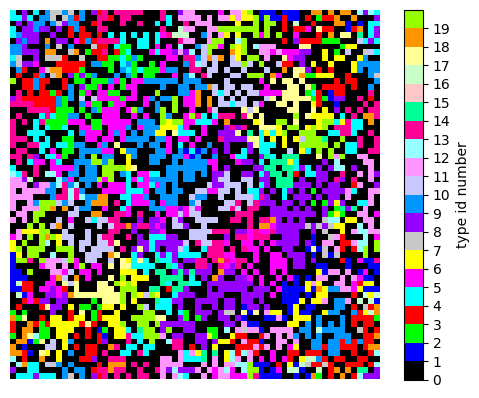


Numbers of cells occupied by each functional type

0 	 C       	 105
1 	 S       	 109
2 	 R       	 200
3 	 SC      	 193
4 	 CR      	 246
5 	 SR      	 150
6 	 CSR     	  37
7 	 C/CR    	 323
8 	 C/SC    	 257
9 	 C/CSR   	 143
10 	 CR/CSR  	 159
11 	 SC/CSR  	  48
12 	 R/CR    	 196
13 	 S/SC    	  45
14 	 R/CSR   	   4
15 	 S/CSR   	  20
16 	 SR/CSR  	  89
17 	 R/SR    	  83
18 	 S/SR    	 153

Weighted total biomass   916.8
Shannon entropy          2.724
CSR                      0.34,0.22,0.45
Nearest type             SR


In [ ]:

run(100)

[62, 31, 64, 86, 152, 72, 29, 208, 161, 93, 120, 29, 116, 7, 1, 1, 39, 31, 76]


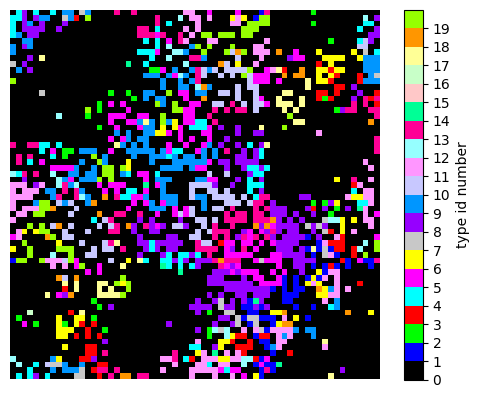


Numbers of cells occupied by each functional type

0 	 C       	  62
1 	 S       	  31
2 	 R       	  64
3 	 SC      	  86
4 	 CR      	 152
5 	 SR      	  72
6 	 CSR     	  29
7 	 C/CR    	 208
8 	 C/SC    	 161
9 	 C/CSR   	  93
10 	 CR/CSR  	 120
11 	 SC/CSR  	  29
12 	 R/CR    	 116
13 	 S/SC    	   7
14 	 R/CSR   	   1
15 	 S/CSR   	   1
16 	 SR/CSR  	  39
17 	 R/SR    	  31
18 	 S/SR    	  76

Weighted total biomass   509.7
Shannon entropy          2.623
CSR                      0.3,0.2,0.5
Nearest type             SR


In [ ]:

disrupt(dnumber,dsize,dstr)
"""
No. of random disruptions per array, size of disrupted squares (cells per side), level of destruction (effect graduated by type)
"""
run(1)

[62, 40, 81, 93, 170, 88, 34, 218, 169, 113, 147, 38, 132, 9, 2, 5, 45, 37, 81]


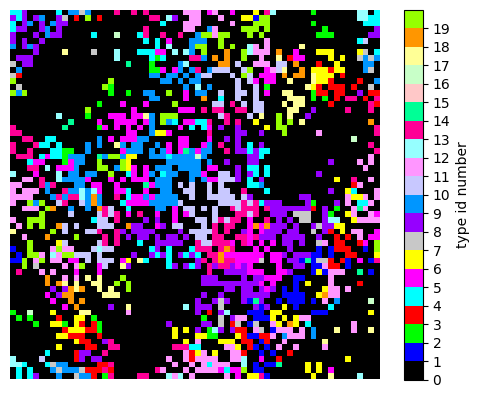


Numbers of cells occupied by each functional type

0 	 C       	  62
1 	 S       	  40
2 	 R       	  81
3 	 SC      	  93
4 	 CR      	 170
5 	 SR      	  88
6 	 CSR     	  34
7 	 C/CR    	 218
8 	 C/SC    	 169
9 	 C/CSR   	 113
10 	 CR/CSR  	 147
11 	 SC/CSR  	  38
12 	 R/CR    	 132
13 	 S/SC    	   9
14 	 R/CSR   	   2
15 	 S/CSR   	   5
16 	 SR/CSR  	  45
17 	 R/SR    	  37
18 	 S/SR    	  81

Weighted total biomass   573.2
Shannon entropy          2.656
CSR                      0.3,0.21,0.49
Nearest type             SR


In [ ]:
run(1)

In [ ]:


data.close()